In [1]:
import cv2
import dlib

import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
import skvideo.io

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rcParams

from tqdm import tqdm

import glob
import json
import pickle
from os.path import join, basename, exists
from os import listdir, makedirs
from collections import defaultdict
from itertools import product
from functools import partial

%matplotlib inline

In [2]:
rcParams['figure.figsize'] = (15, 15)

In [3]:
predictor_path = './models/shape_predictor_68_face_landmarks.dat'
face_rec_model_path = './models/dlib_face_recognition_resnet_model_v1.dat'

# detector = dlib.get_frontal_face_detector()
cnn_face_detector = dlib.cnn_face_detection_model_v1('./models/mmod_human_face_detector.dat')
sp = dlib.shape_predictor(predictor_path)
facerec = dlib.face_recognition_model_v1(face_rec_model_path)

In [4]:
video_paths = glob.glob('../data/faces/known/*')

In [5]:
def show_images(images, num_rows, num_cols, additional_info=None, colorbar=False):
#     num_cols = 6
#     num_rows = len(class_idxs) // num_cols + (1 if len(class_idxs) % num_cols != 0 else 0)
    plt.figure(figsize=(15, 15))
    gs = gridspec.GridSpec(num_rows, num_cols, top=1., bottom=0., right=1., left=0., hspace=0., wspace=0.0)

    for i in range(min(num_rows*num_cols, len(images))):
        image = images[i]
        if len(image.shape) >= 3:
            width, height, _ = image.shape
        else:
            width, height = image.shape
        if additional_info is not None:
            color = (0, 0, 255)
            dst = cv2.putText(image, str(additional_info[i]), (0, 400),
                          cv2.FONT_HERSHEY_SIMPLEX, width/254, (255, 255, 255), width//100, cv2.LINE_AA)
        else:
            dst = image

        ax = plt.subplot(gs[i])
        im = ax.imshow(dst, cmap='coolwarm', vmin=-15., vmax=15.)
        if colorbar:
            plt.colorbar(im, ax=ax)
        ax.set_xticks([])
        ax.set_yticks([])

In [6]:
def draw_detected_faces(img, dets):
    dst = img.copy()
    for d in dets:
        cv2.rectangle(dst, (d.left(), d.top()), (d.right(), d.bottom()), (0, 0, 255), 3)
    
    return dst

In [7]:
def add_face(face_descriptor, face_img, frame_idx, bbox, faces):
    if (face_img.shape[0] > 0) and (face_img.shape[1] > 0):
        face_img = cv2.resize(face_img, (48, 48))
        faces['frame_idxs'].append(frame_idx)
        faces['descriptors'].append(face_descriptor)
        faces['bboxes'].append(bbox)
        faces['face_imgs'].append(face_img)

def dump_faces(faces, dump_path):
    if len(faces) == 0:
        return
    
    frame_idxs = np.array(faces['frame_idxs'])[..., np.newaxis]
    face_descriptors = np.array(faces['descriptors'])
    bboxes = np.array(faces['bboxes'])
    face_images = np.array(list(map(lambda face_img: face_img.ravel(), faces['face_imgs'])))
    faces_matrix = np.hstack([frame_idxs, face_descriptors, bboxes, face_images])
    
    np.save(dump_path, faces_matrix)

In [8]:
def detect_faces_video(detector, video_path, out_path):
    cap = cv2.VideoCapture(video_path)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    h, w = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    if h < w:
        out = cv2.VideoWriter(out_path, fourcc, cap.get(cv2.CAP_PROP_FPS), (w, h)[::-1])
    else:
        out = cv2.VideoWriter(out_path, fourcc, cap.get(cv2.CAP_PROP_FPS), (w, h))
    
    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    for i in tqdm(range(n_frames)):
        ok, frame = cap.read()

        if not ok:
            break

        frame = frame[..., ::-1]
        if h < w:
            frame = frame.transpose((1, 0, 2))
        
        dets = detector(frame, 1)
        dets = [d.rect for d in dets]
        dst = draw_detected_faces(frame, dets)

        out.write(dst[..., ::-1])

    out.release()
    cap.release()

In [9]:
def collect_faces_video(detector, video_path, skip_frames=10, out_path=None):
    cap = cv2.VideoCapture(video_path)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    h, w = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    if out_path is not None:
        if h < w:
            out = cv2.VideoWriter(out_path, fourcc, cap.get(cv2.CAP_PROP_FPS), (w, h)[::-1])
        else:
            out = cv2.VideoWriter(out_path, fourcc, cap.get(cv2.CAP_PROP_FPS), (w, h))
    else:
        out = None
    
    faces = defaultdict(list)
    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    for i in tqdm(range(0, n_frames, skip_frames)):
        cap.set(1, i)
        ok, frame = cap.read()

        if not ok:
            break

        frame = frame[..., ::-1]
        if h < w:
            frame = frame.transpose((1, 0, 2))
        
        dets = detector(frame, 1)
        dets = [d.rect for d in dets]
        for d in dets:
            shape = sp(frame, d)
            face_descriptor = facerec.compute_face_descriptor(frame, shape)
            face_descriptor = np.array(face_descriptor)

            bbox = d.top(), d.left(), d.bottom(), d.right()
            face_img = frame[d.top():d.bottom(), d.left():d.right()]
            add_face(face_descriptor, face_img, i, bbox, faces)

        dst = draw_detected_faces(frame, dets)
        
        if out is not None:
            out.write(dst[..., ::-1])

    if out is not None:
        out.release()
    cap.release()
    
    return faces

166


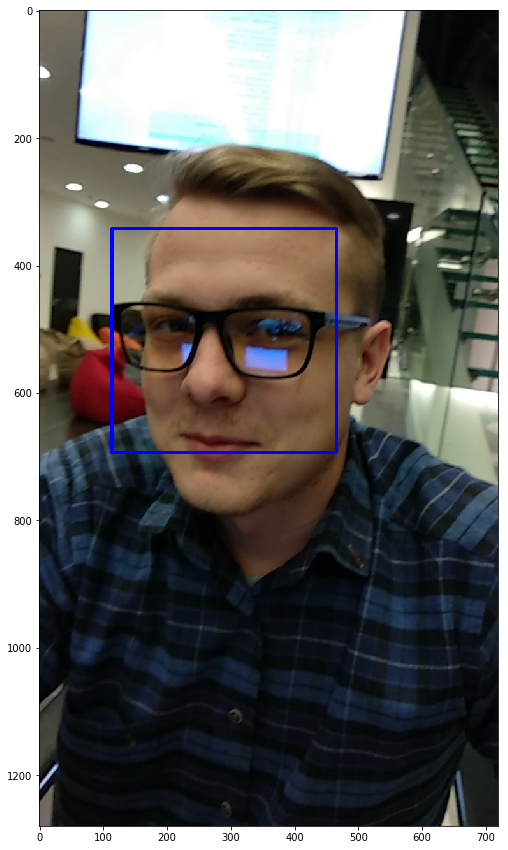

In [10]:
# cap = cv2.VideoCapture(video_paths[3])
cap = cv2.VideoCapture('../data/faces/unknown/unknown.mp4')
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(n_frames)
cap.set(1, 40)

_, img = cap.read()
img = img[..., ::-1]
img = img.transpose((1, 0, 2))
cap.release()

dets = cnn_face_detector(img, 1)
dets = [d.rect for d in dets]
dst = draw_detected_faces(img, dets)
imshow(dst)

In [35]:
detect_faces_video(cnn_face_detector, video_paths[1], '../data/faces/tmp.mp4')

100%|██████████| 172/172 [00:58<00:00,  2.94it/s]


In [36]:
faces = collect_faces_video(cnn_face_detector, video_paths[1], '../data/faces/tmp.mp4')

100%|██████████| 1000/1000 [01:57<00:00,  8.51it/s]


In [ ]:
face_descriptors = np.array(list(map(lambda face: face['descriptor'], faces)))

## Dump faces from all videos

In [14]:
for i, video_path in enumerate(video_paths):
    print('Video {}/{}...'.format(i + 1, len(video_paths)))
    faces = collect_faces_video(cnn_face_detector, video_path, skip_frames=10, out_path=None)
    dump_fname = basename(video_path)[:-4] + '.npy'
    dump_faces(faces, join('./descriptors/known/', dump_fname))

  0%|          | 0/15 [00:00<?, ?it/s]

Video 1/4...


  0%|          | 0/18 [00:00<?, ?it/s]

Video 2/4...


  0%|          | 0/24 [00:00<?, ?it/s]

Video 3/4...


  0%|          | 0/22 [00:00<?, ?it/s]

Video 4/4...


100%|██████████| 22/22 [00:08<00:00,  2.48it/s]


In [12]:
descr_dir = './descriptors/known/'

In [13]:
all_descr_ = []
all_colors_ = []
for i, video_path in enumerate(video_paths):
    video_name = basename(video_path)[:-4]
    descr_path = join(descr_dir, video_name + '.npy')
    
    faces = np.load(descr_path)
    all_descr_.append(faces[:, 1:129])
    all_colors_.append(np.full((len(faces), 1), i, dtype=np.int32))
all_descr = np.vstack(all_descr_)
all_colors = np.vstack(all_colors_).squeeze()
# np.save('./descriptors/known_descriptors.npy', all_descr)

In [65]:
k_people = len(video_paths)

In [70]:
pipe = Pipeline([
    ('pca', PCA(n_components=5)),
    ('kmeans', KMeans(n_clusters=k_people))
])

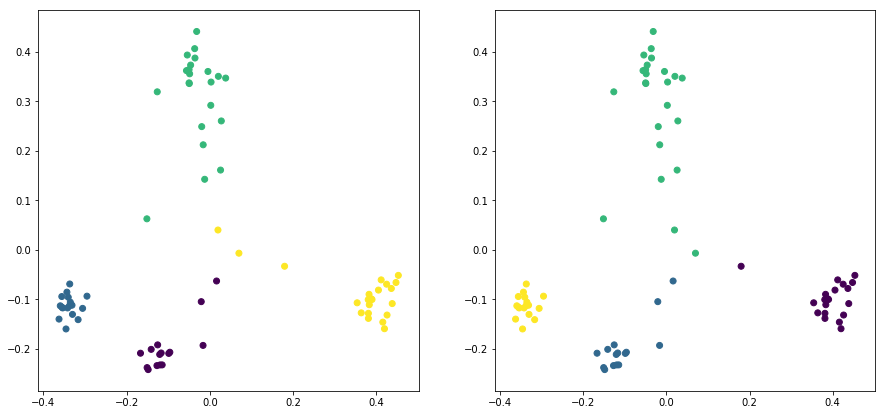

In [71]:
pipe.fit(all_descr)
clusters = pipe.predict(all_descr)

descriptors2d = PCA(n_components=2).fit_transform(all_descr)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].scatter(list(zip(*descriptors2d))[0], list(zip(*descriptors2d))[1], c=all_colors)
ax[1].scatter(list(zip(*descriptors2d))[0], list(zip(*descriptors2d))[1], c=clusters)

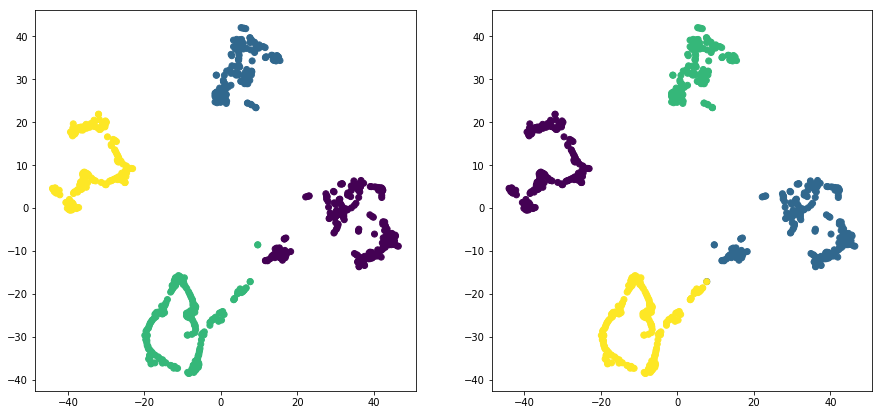

In [57]:
descriptorsNd = PCA(n_components=10).fit_transform(all_descr)
descriptors2d = TSNE(n_components=2).fit_transform(all_descr)
# clusters = kmeans.fit_predict(all_descr)
clusters = kmeans.fit_predict(descriptorsNd)

fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].scatter(list(zip(*descriptors2d))[0], list(zip(*descriptors2d))[1], c=all_colors)
ax[1].scatter(list(zip(*descriptors2d))[0], list(zip(*descriptors2d))[1], c=clusters)

In [72]:
centroids = pipe.named_steps['kmeans'].cluster_centers_
n_faces = len(centroids)
dist_matrix = np.empty((n_faces, n_faces))

In [73]:
for i in range(n_faces):
    cur_descriptors = all_descr_[i]
    cur_descriptors = pipe.named_steps['pca'].transform(cur_descriptors)
        
    for j in range(n_faces):
        cur_centroid = centroids[j]

        distances = np.linalg.norm(cur_descriptors - cur_centroid, axis=1)
        avg_dist = np.mean(distances)
        dist_matrix[i, j] = avg_dist

In [74]:
dist_matrix = (dist_matrix - dist_matrix.min()) / (dist_matrix.max() - dist_matrix.min())

In [75]:
rcParams['figure.figsize'] = (5, 5)

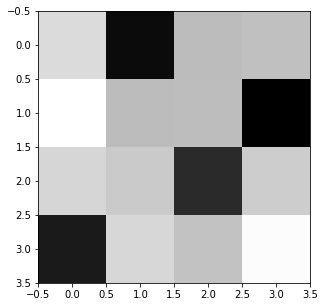

In [76]:
imshow(dist_matrix, cmap='gray')

In [77]:
np.sort(dist_matrix.ravel())[:k_people]

array([0.        , 0.04339088, 0.10374278, 0.16710463])

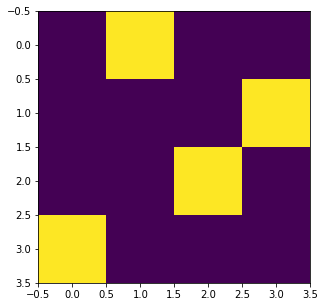

In [78]:
imshow(dist_matrix < 0.6)

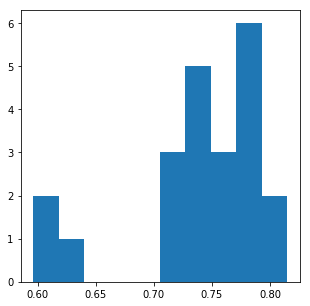

In [79]:
plt.hist(distances);

### Building faces database

In [14]:
PEOPLE_CENTROIDS_PATH = './faces_db/centroids.json'
PIPE_PATH = './faces_db/pipe.pickle'
PCA_DIM = 5
SIMILARITY_THRESHOLD = 0.3

def load_people_centroids(p_centroids_path):
    if not exists(p_centroids_path):
        with open(p_centroids_path, 'w') as f:
            f.write('[]\n')
    
    with open(p_centroids_path, 'r') as f:
        p_centroids = json.load(f)
    
    return p_centroids

def save_people_centroids(p_centroids, p_centroids_path):
    with open(p_centroids_path, 'w') as f:
        json.dump(p_centroids, f)

def dump_pipe(pipe, pipe_path):
    with open(pipe_path, 'wb') as f:
        pickle.dump(pipe, f)

def load_pipe(pipe_path):
    with open(pipe_path, 'rb') as f:
        pipe = pickle.load(f)
    
    return pipe

def calc_distance(descriptor1, descriptor2):
    return np.linalg.norm(descriptor1 - descriptor2)

def calc_distance_multiple_descriptors(centroid, descriptors):
    distances = np.linalg.norm(descriptors - centroid, axis=1)
    avg_dist = np.mean(distances)
    
    return avg_dist

def find_closest_centroid(centroids, descriptors):
    dists = np.apply_along_axis(partial(calc_distance_multiple_descriptors, descriptors=descriptors), 1, centroids)
    closest_id = np.argmin(dists)
    
    return centroids[closest_id], dists[closest_id]

def find_closest_person(p_centroids, descriptor):
    all_centroids = [p_centroid['centroid'] for p_centroid in p_centroids]
    centroid_dists = [calc_distance(descriptor, centroid) for centroid in all_centroids]
#     centroid_dists = list(map(partial(calc_distance, descriptor1=descriptor), all_centroids))
    closest_id = np.argmin(centroid_dists)
    
    dist = centroid_dists[closest_id]
    
    if dist > SIMILARITY_THRESHOLD:
        return False, ''  # there is no person with similar descriptor
    else:
        person_name = p_centroids[closest_id]['name']
        return True, person_name
    
def transform_descriptor(descriptor, pipe):
    descriptorNd = pipe.named_steps['pca'].transform([descriptor])
    
    return descriptorNd
    
def add_person_centroid(p_centroids_path, centroid, person_name):
    p_centroids = load_people_centroids(p_centroids_path)
    p_centroids.append({'centroid': list(centroid), 'name': person_name})
    save_people_centroids(p_centroids, p_centroids_path)

def add_person(descriptors, person_name, video_name):
    p_centroids = load_people_centroids()
    if len(p_centroids) == 0:
        # TODO call PCA
        avg_descriptor = np.mean(descriptors)
        add_person_centroid(PEOPLE_CENTROIDS_PATH, avg_centroid, person_name)
        
        return (True, '')
    
#     for p_centroid in p_centroids:
#         name, centroid = p_centroid['name'], p_centroid['centroid']
#         if 

In [15]:
# dump_pipe(pipe, PIPE_PATH)
pipe = load_pipe(PIPE_PATH)

In [20]:
p_centroids = []
centroids = pipe.named_steps['kmeans'].cluster_centers_
for i, (video_path, descriptors) in enumerate(zip(video_paths, all_descr_)):
    person_name = basename(video_path)[:-4]
    descriptorsNd = pipe.named_steps['pca'].transform(descriptors)
    closest_centroid, _ = find_closest_centroid(centroids, descriptorsNd)
    
    p_centroids.append({
        'name': person_name,
        'centroid': list(closest_centroid)
    })

In [21]:
save_people_centroids(p_centroids, PEOPLE_CENTROIDS_PATH)

In [103]:
cap = cv2.VideoCapture(video_paths[3])
cap.set(1, 50)

_, img = cap.read()
img = img[..., ::-1]
img = img.transpose((1, 0, 2))
cap.release()

In [13]:
def get_person_descriptor(img):
    dets = cnn_face_detector(img, 1)
    
    if len(dets) > 1:
        raise Exception('Sorry. There are more than one person on the image')
    
    detection = dets[0].rect
    shape = sp(img, detection)
    face_descriptor = facerec.compute_face_descriptor(img, shape)
    face_descriptor = np.array(face_descriptor)
    
    return face_descriptor

In [14]:
pipe = load_pipe(PIPE_PATH)
p_centroids = load_people_centroids(PEOPLE_CENTROIDS_PATH)

In [21]:
img = cv2.imread('../data/faces/real_photos/alice.jpg')

face_descriptor = get_person_descriptor(img)
descriptor = transform_descriptor(face_descriptor, pipe)
find_closest_person(p_centroids, descriptor)

(False, '')

### Record all videos with detection results

In [14]:
for i, video_path in enumerate(video_paths):
    print('Video {}/{}...'.format(i + 1, len(video_paths)))
    fname = basename(video_path)[:-4]
    faces = detect_faces_video(cnn_face_detector, video_path, './data/faces/detected_{}.mp4'.format(fname))

  0%|          | 0/3000 [00:00<?, ?it/s]

Video 2/4...


  0%|          | 1/2999 [00:00<05:37,  8.88it/s]

Video 3/4...


  0%|          | 1/3000 [00:00<05:38,  8.85it/s]

Video 4/4...


100%|██████████| 3000/3000 [05:26<00:00,  9.18it/s]
